In [ ]:
from google.colab import drive
import os
import sys

In [1]:
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive/MS.c. Project')
os.chdir('/content/gdrive/MyDrive/MS.c. Project')

NameError: ignored

#Import

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import numpy as np
from os import path
import IPython
import torch
import json
from StackedHourGlass import StackedHourGlass
from parameter import parameters
from dataset import dataset_reader
from metrics import JointsMeanSquaredError
from Essential import print_table
from train import train, validate, initialize_checkpoint, update_performance_metrics, update_best_performance, save_checkpoint, run_test_and_save_results, test_best_model_on_datasets

#Main

In [ ]:
def main(pars):
    # 1. Initialization: Data and Model
    n_jt = dataset_reader.joint_num_ori

    # Initialize the model
    model = StackedHourGlass(channel_count=pars.nChannels,
                             stack_count= pars.nStack,
                             module_count=pars.nModules,
                             reduction_count=pars.numReductions,
                             input_channels=pars.num_channels,
                             joint_count=n_jt,
                             multi_loss=pars.mu_loss)

    # Define the device and move the model to the appropriate device
    device = torch.device("cuda" if pars.use_gpu else "cpu")
    model = model.to(device)

    # Define the loss function
    criterion = JointsMeanSquaredError(use_target_weight=True).to(device)

    # 2. Load Datasets
    train_dataset = dataset_reader(pars=pars, phase='train', zero_base=True)
    test_dataset = dataset_reader(pars, phase='test', zero_base=True)


    # 3. Initialize Data Loaders
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=pars.batch_size,
                              shuffle=True,
                              pin_memory=pars.pin_memory)
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=pars.batch_size,
                             shuffle=False,
                             pin_memory=pars.pin_memory)

     # 4. Initialize the optimizer and scheduler
    optimizer = Adam(model.parameters(), lr=pars.learning_rate)
    (begin_epoch, train_losses, train_accs, val_losses, val_accs,best_perf, last_epoch) = initialize_checkpoint(pars, model, optimizer)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, pars.lr_decay_epochs, pars.lr_decay_factor, last_epoch=last_epoch)
    end_epoch = pars.end_epoch if pars.epoch_step <= 0 else min(pars.end_epoch, pars.start_epoch + pars.epoch_step)

     # 5. Wrap the model for multi-GPUs
    model = torch.nn.DataParallel(model).to(device)

    # 6. Training Loop
    if not pars.perform_test:
        for epoch in range(begin_epoch, end_epoch):
            # Training phase
            train_results = train(train_loader=train_loader,
                                  val_loader=train_dataset,
                                  model=model,
                                  loss_func=criterion,
                                  optimizer=optimizer,
                                  epoch=epoch,
                                  params=pars,
                                  max_iterations=pars.trainIter,
                                  use_gpu=pars.use_gpu)

            # Accumulate training metrics
            train_losses += train_results['losses']
            train_accs += train_results['accs']

            # Validation phase
            test_results = validate(loader=test_loader,
                                    dataset_reader=test_dataset,
                                    model=model,
                                    loss_function=criterion,
                                    max_iterations=pars.trainIter,
                                    epoch=epoch,
                                    params=pars,
                                    phase='val',
                                    save_visuals=True,
                                    use_gpu=pars.use_gpu)


            # Accumulate validation metrics
            val_losses += test_results['losses']
            val_accs += test_results['accs']

            # Update the best performance metrics
            current_perf = update_performance_metrics(test_results, test_dataset)
            best_perf, best_model = update_best_performance(current_perf, best_perf)

            # Save checkpoints
            save_checkpoint(pars, model, optimizer, epoch, best_model, best_perf, train_losses, train_accs, val_losses, val_accs)

    # 7. Run tests and save results
    run_test_and_save_results(pars, dataset_reader, model, criterion, 'danaLab', pars.trainIter)

    # Additional testing conditions
    if 'PM' not in pars.source_modes:
      pars.data_path = 'SLP/simLab'
      run_test_and_save_results(pars, dataset_reader, model, criterion, 'simLab', pars.trainIter)
      if pars.cover_list != ['uncover', 'cover1', 'cover2']:
        run_test_and_save_results(pars, dataset_reader, model, criterion, 'simLab_all', pars.trainIter, covers=['uncover', 'cover1', 'cover2'])

#Run Training

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR'], cover_list=['uncover'],end_epoch=5, nChannels=256, nStack=2, nModules=2,numReductions=4,output_dir='test_out/')
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
=> loading checkpoint 'test_out/StackedHourGlass_256_2_2_4multi_loss/SLP_IR___u/model_dump/checkpoint.pth'
=> loaded checkpoint 'test_out/StackedHourGlass_256_2_2_4multi_loss/SLP_IR___u/model_dump/checkpoint.pth' (epoch 5)
---------run final test danaLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/18]	Loss 0.00067	Accuracy 0.814
Test: [10/18]	Loss 0.00068	Accuracy 0.812
|          || R_Ankle  ||  R_Knee  ||  R_Hip   ||  L_Hip   ||  L_Knee  || L_Ankle  || R_Wrist  || R_Elbow  ||R_Shoulder||L_Shoulder|| L_Elbow  || L_Wrist  ||  Thorax  ||   Head   ||  total   |
|pckh0.5   |   68.7   ||   76.3   ||   67.0   ||   68.5   ||   71.9   ||   66.3   ||   51.9   ||   62.2   ||   76.3   ||   71.5   ||   59.8   ||   50.4   ||   96.9   ||   96.7   ||   70.3   |
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: do

##SLP_IR_Uncover

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR'], cover_list=['uncover'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/135]	Loss: 0.07057	Accuracy: 0.021
Epoch: [0][10/135]	Loss: 0.00564	Accuracy: 0.109
Epoch: [0][20/135]	Loss: 0.00562	Accuracy: 0.141
Epoch: [0][30/135]	Loss: 0.00381	Accuracy: 0.204
Epoch: [0][40/135]	Loss: 0.00298	Accuracy: 0.249
Epoch: [0][50/135]	Loss: 0.00282	Accuracy: 0.163
Epoch: [0][60/135]	Loss: 0.00279	Accuracy: 0.254
Epoch: [0][70/135]	Loss: 0.00274	Accuracy: 0.257
Epoch: [0][80/135]	Loss: 0.00273	Accuracy: 0.249
Epoch: [0][90/135]	Loss: 0.00269	Accuracy: 0.268
Epoch: [0][100/135]	Loss: 0.00265	Accuracy: 0.258
Epoch: [0][110/135]	Loss: 0.00261	Accuracy: 0.294
Epoch: [0][120/135]	Loss: 0.00261	Accuracy: 0.348
Epoch: [0][130/135]	Loss: 0.00256	Accuracy: 0.297
Test: [0/18]	Loss 0.00117	Accuracy 0.417
Test: [10/18]	Loss 0.00119	Accuracy 0.469
|          || R_Ankle  ||  R_Knee  ||  R_Hip   ||  L_Hip   ||  L_Knee  || L_Ankle  || R_Wrist  || R_Elbow  ||R_Sho

##SLP_IR_Cover1

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR'], cover_list=['cover1'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/135]	Loss: 0.11649	Accuracy: 0.049
Epoch: [0][10/135]	Loss: 0.00544	Accuracy: 0.126
Epoch: [0][20/135]	Loss: 0.00444	Accuracy: 0.154
Epoch: [0][30/135]	Loss: 0.00351	Accuracy: 0.128


KeyboardInterrupt: ignored

##SLP_IR_Cover2

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR'], cover_list=['cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/135]	Loss 0.11099	Accuracy 0.057
Epoch: [0][10/135]	Loss 0.00684	Accuracy 0.119
Epoch: [0][20/135]	Loss 0.00593	Accuracy 0.152
Epoch: [0][30/135]	Loss 0.00423	Accuracy 0.160
Epoch: [0][40/135]	Loss 0.00314	Accuracy 0.185
Epoch: [0][50/135]	Loss 0.00292	Accuracy 0.200
Epoch: [0][60/135]	Loss 0.00282	Accuracy 0.194
Epoch: [0][70/135]	Loss 0.00280	Accuracy 0.182
Epoch: [0][80/135]	Loss 0.00285	Accuracy 0.156
Epoch: [0][90/135]	Loss 0.00270	Accuracy 0.227
Epoch: [0][100/135]	Loss 0.00270	Accuracy 0.223
Epoch: [0][110/135]	Loss 0.00272	Accuracy 0.210
Epoch: [0][120/135]	Loss 0.00263	Accuracy 0.247
Epoch: [0][130/135]	Loss 0.00270	Accuracy 0.216
Test: [0/18]	Loss 0.00121	Accuracy 0.390
Test: [10/18]	Loss 0.00128	Accuracy 0.290
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax    

##SLP_IR_total

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/405]	Loss: 0.08904	Accuracy: 0.046
Epoch: [0][10/405]	Loss: 0.00610	Accuracy: 0.099
Epoch: [0][20/405]	Loss: 0.00652	Accuracy: 0.090
Epoch: [0][30/405]	Loss: 0.00384	Accuracy: 0.195
Epoch: [0][40/405]	Loss: 0.00300	Accuracy: 0.191
Epoch: [0][50/405]	Loss: 0.00297	Accuracy: 0.197
Epoch: [0][60/405]	Loss: 0.00289	Accuracy: 0.192
Epoch: [0][70/405]	Loss: 0.00277	Accuracy: 0.168
Epoch: [0][80/405]	Loss: 0.00275	Accuracy: 0.230
Epoch: [0][90/405]	Loss: 0.00276	Accuracy: 0.235
Epoch: [0][100/405]	Loss: 0.00276	Accuracy: 0.228
Epoch: [0][110/405]	Loss: 0.00269	Accuracy: 0.226
Epoch: [0][120/405]	Loss: 0.00265	Accuracy: 0.277
Epoch: [0][130/405]	Loss: 0.00262	Accuracy: 0.256
Epoch: [0][140/405]	Loss: 0.00266	Accuracy: 0.307
Epoch: [0][150/405]	Loss: 0.00263	Accuracy: 0.262
Epoch: [0][160/405]	Loss: 0.00263	Accuracy: 0.263
Epoch: [0][170/405]	Loss: 0.00261	Accuracy: 0.2

##SLP_PM_Uncover

In [ ]:
pars = parameters(use_gpu=True, source_modes=['PM'], cover_list=['uncover'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/135]	Loss 0.06582	Accuracy 0.042
Epoch: [0][10/135]	Loss 0.00937	Accuracy 0.063
Epoch: [0][20/135]	Loss 0.00714	Accuracy 0.083
Epoch: [0][30/135]	Loss 0.00363	Accuracy 0.109
Epoch: [0][40/135]	Loss 0.00298	Accuracy 0.118
Epoch: [0][50/135]	Loss 0.00309	Accuracy 0.119
Epoch: [0][60/135]	Loss 0.00289	Accuracy 0.132
Epoch: [0][70/135]	Loss 0.00288	Accuracy 0.127
Epoch: [0][80/135]	Loss 0.00275	Accuracy 0.164
Epoch: [0][90/135]	Loss 0.00283	Accuracy 0.197
Epoch: [0][100/135]	Loss 0.00280	Accuracy 0.172
Epoch: [0][110/135]	Loss 0.00280	Accuracy 0.213
Epoch: [0][120/135]	Loss 0.00275	Accuracy 0.221
Epoch: [0][130/135]	Loss 0.00274	Accuracy 0.176
Test: [0/18]	Loss 0.00131	Accuracy 0.298
Test: [10/18]	Loss 0.00136	Accuracy 0.262
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax    

##SLP_PM_cover1

In [ ]:
pars = parameters(use_gpu=True, source_modes=['PM'], cover_list=['cover1'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/135]	Loss 0.07139	Accuracy 0.055
Epoch: [0][10/135]	Loss 0.00847	Accuracy 0.060
Epoch: [0][20/135]	Loss 0.00686	Accuracy 0.084
Epoch: [0][30/135]	Loss 0.00420	Accuracy 0.085
Epoch: [0][40/135]	Loss 0.00309	Accuracy 0.084
Epoch: [0][50/135]	Loss 0.00301	Accuracy 0.100
Epoch: [0][60/135]	Loss 0.00293	Accuracy 0.151
Epoch: [0][70/135]	Loss 0.00292	Accuracy 0.153
Epoch: [0][80/135]	Loss 0.00280	Accuracy 0.153
Epoch: [0][90/135]	Loss 0.00280	Accuracy 0.174
Epoch: [0][100/135]	Loss 0.00285	Accuracy 0.180
Epoch: [0][110/135]	Loss 0.00280	Accuracy 0.185
Epoch: [0][120/135]	Loss 0.00275	Accuracy 0.198
Epoch: [0][130/135]	Loss 0.00276	Accuracy 0.189
Test: [0/18]	Loss 0.00130	Accuracy 0.398
Test: [10/18]	Loss 0.00135	Accuracy 0.271
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax    

##SLP_PM_cover2

In [ ]:
pars = parameters(use_gpu=True, source_modes=['PM'], cover_list=['cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/135]	Loss 0.10264	Accuracy 0.046
Epoch: [0][10/135]	Loss 0.00766	Accuracy 0.051
Epoch: [0][20/135]	Loss 0.00568	Accuracy 0.070
Epoch: [0][30/135]	Loss 0.00416	Accuracy 0.080
Epoch: [0][40/135]	Loss 0.00336	Accuracy 0.094
Epoch: [0][50/135]	Loss 0.00294	Accuracy 0.104
Epoch: [0][60/135]	Loss 0.00298	Accuracy 0.118
Epoch: [0][70/135]	Loss 0.00295	Accuracy 0.118
Epoch: [0][80/135]	Loss 0.00277	Accuracy 0.147
Epoch: [0][90/135]	Loss 0.00278	Accuracy 0.157
Epoch: [0][100/135]	Loss 0.00275	Accuracy 0.166
Epoch: [0][110/135]	Loss 0.00273	Accuracy 0.208
Epoch: [0][120/135]	Loss 0.00274	Accuracy 0.244
Epoch: [0][130/135]	Loss 0.00278	Accuracy 0.250
Test: [0/18]	Loss 0.00130	Accuracy 0.360
Test: [10/18]	Loss 0.00134	Accuracy 0.274
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax    

##SLP_PM_total

In [ ]:
pars = parameters(use_gpu=True, source_modes=['PM'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/405]	Loss: 0.09340	Accuracy: 0.048
Epoch: [0][10/405]	Loss: 0.00570	Accuracy: 0.065
Epoch: [0][20/405]	Loss: 0.00494	Accuracy: 0.085
Epoch: [0][30/405]	Loss: 0.00396	Accuracy: 0.119
Epoch: [0][40/405]	Loss: 0.00312	Accuracy: 0.104
Epoch: [0][50/405]	Loss: 0.00302	Accuracy: 0.107
Epoch: [0][60/405]	Loss: 0.00288	Accuracy: 0.121
Epoch: [0][70/405]	Loss: 0.00284	Accuracy: 0.125
Epoch: [0][80/405]	Loss: 0.00279	Accuracy: 0.202
Epoch: [0][90/405]	Loss: 0.00282	Accuracy: 0.134
Epoch: [0][100/405]	Loss: 0.00282	Accuracy: 0.158
Epoch: [0][110/405]	Loss: 0.00276	Accuracy: 0.201
Epoch: [0][120/405]	Loss: 0.00273	Accuracy: 0.214
Epoch: [0][130/405]	Loss: 0.00271	Accuracy: 0.236
Epoch: [0][140/405]	Loss: 0.00274	Accuracy: 0.255
Epoch: [0][150/405]	Loss: 0.00266	Accuracy: 0.289
Epoch: [0][160/405]	Loss: 0.00271	Accuracy: 0.203
Epoch: [0][170/405]	Loss: 0.00266	Accuracy: 0.2

KeyboardInterrupt: ignored

##SLP_Depth_Uncover

In [ ]:
pars = parameters(use_gpu=True, source_modes=['depth'], cover_list=['uncover'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/135]	Loss 0.07179	Accuracy 0.000
Epoch: [0][10/135]	Loss 0.01006	Accuracy 0.010
Epoch: [0][20/135]	Loss 0.00537	Accuracy 0.014
Epoch: [0][30/135]	Loss 0.00377	Accuracy 0.033
Epoch: [0][40/135]	Loss 0.00338	Accuracy 0.041
Epoch: [0][50/135]	Loss 0.00313	Accuracy 0.079
Epoch: [0][60/135]	Loss 0.00305	Accuracy 0.120
Epoch: [0][70/135]	Loss 0.00301	Accuracy 0.150
Epoch: [0][80/135]	Loss 0.00297	Accuracy 0.145
Epoch: [0][90/135]	Loss 0.00295	Accuracy 0.193
Epoch: [0][100/135]	Loss 0.00296	Accuracy 0.207
Epoch: [0][110/135]	Loss 0.00291	Accuracy 0.212
Epoch: [0][120/135]	Loss 0.00288	Accuracy 0.226
Epoch: [0][130/135]	Loss 0.00282	Accuracy 0.279
Test: [0/18]	Loss 0.00127	Accuracy 0.529
Test: [10/18]	Loss 0.00129	Accuracy 0.417
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax    

##SLP_Depth_cover1

In [ ]:
pars = parameters(use_gpu=True, source_modes=['depth'], cover_list=['cover1'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/135]	Loss 0.07953	Accuracy 0.002
Epoch: [0][10/135]	Loss 0.00768	Accuracy 0.005
Epoch: [0][20/135]	Loss 0.00481	Accuracy 0.021
Epoch: [0][30/135]	Loss 0.00365	Accuracy 0.021
Epoch: [0][40/135]	Loss 0.00332	Accuracy 0.067
Epoch: [0][50/135]	Loss 0.00316	Accuracy 0.077
Epoch: [0][60/135]	Loss 0.00305	Accuracy 0.117
Epoch: [0][70/135]	Loss 0.00299	Accuracy 0.133
Epoch: [0][80/135]	Loss 0.00298	Accuracy 0.164
Epoch: [0][90/135]	Loss 0.00294	Accuracy 0.165
Epoch: [0][100/135]	Loss 0.00290	Accuracy 0.193
Epoch: [0][110/135]	Loss 0.00289	Accuracy 0.238
Epoch: [0][120/135]	Loss 0.00289	Accuracy 0.183
Epoch: [0][130/135]	Loss 0.00283	Accuracy 0.245
Test: [0/18]	Loss 0.00128	Accuracy 0.412
Test: [10/18]	Loss 0.00130	Accuracy 0.336
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax    

##SLP_Depth_cover2

In [ ]:
pars = parameters(use_gpu=True, source_modes=['depth'], cover_list=['cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/135]	Loss 0.07837	Accuracy 0.002
Epoch: [0][10/135]	Loss 0.00786	Accuracy 0.014
Epoch: [0][20/135]	Loss 0.00453	Accuracy 0.031
Epoch: [0][30/135]	Loss 0.00369	Accuracy 0.033
Epoch: [0][40/135]	Loss 0.00320	Accuracy 0.074
Epoch: [0][50/135]	Loss 0.00313	Accuracy 0.062
Epoch: [0][60/135]	Loss 0.00305	Accuracy 0.102
Epoch: [0][70/135]	Loss 0.00299	Accuracy 0.145
Epoch: [0][80/135]	Loss 0.00299	Accuracy 0.138
Epoch: [0][90/135]	Loss 0.00293	Accuracy 0.202
Epoch: [0][100/135]	Loss 0.00299	Accuracy 0.117
Epoch: [0][110/135]	Loss 0.00294	Accuracy 0.179
Epoch: [0][120/135]	Loss 0.00288	Accuracy 0.155
Epoch: [0][130/135]	Loss 0.00284	Accuracy 0.224
Test: [0/18]	Loss 0.00129	Accuracy 0.412
Test: [10/18]	Loss 0.00130	Accuracy 0.395
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax    

##SLP_Depth_total

In [ ]:
pars = parameters(use_gpu=True, source_modes=['depth'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

##SLP_IR+PM_total

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR', 'PM'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/405]	Loss 0.10233	Accuracy 0.052
Epoch: [0][10/405]	Loss 0.00662	Accuracy 0.088
Epoch: [0][20/405]	Loss 0.00583	Accuracy 0.161
Epoch: [0][30/405]	Loss 0.00409	Accuracy 0.161
Epoch: [0][40/405]	Loss 0.00320	Accuracy 0.227
Epoch: [0][50/405]	Loss 0.00283	Accuracy 0.194
Epoch: [0][60/405]	Loss 0.00284	Accuracy 0.193
Epoch: [0][70/405]	Loss 0.00283	Accuracy 0.219
Epoch: [0][80/405]	Loss 0.00274	Accuracy 0.243
Epoch: [0][90/405]	Loss 0.00277	Accuracy 0.205
Epoch: [0][100/405]	Loss 0.00280	Accuracy 0.259
Epoch: [0][110/405]	Loss 0.00269	Accuracy 0.262
Epoch: [0][120/405]	Loss 0.00266	Accuracy 0.268
Epoch: [0][130/405]	Loss 0.00272	Accuracy 0.245
Epoch: [0][140/405]	Loss 0.00264	Accuracy 0.304
Epoch: [0][150/405]	Loss 0.00265	Accuracy 0.238
Epoch: [0][160/405]	Loss 0.00265	Accuracy 0.266
Epoch: [0][170/405]	Loss 0.00263	Accuracy 0.271
Epoch: [0][180/405]	Loss 0.00261	

##SLP_IR+Depth_total

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR', 'depth'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/405]	Loss 0.05459	Accuracy 0.022
Epoch: [0][10/405]	Loss 0.00909	Accuracy 0.062
Epoch: [0][20/405]	Loss 0.00603	Accuracy 0.066
Epoch: [0][30/405]	Loss 0.00364	Accuracy 0.123
Epoch: [0][40/405]	Loss 0.00325	Accuracy 0.111
Epoch: [0][50/405]	Loss 0.00296	Accuracy 0.178
Epoch: [0][60/405]	Loss 0.00286	Accuracy 0.191
Epoch: [0][70/405]	Loss 0.00282	Accuracy 0.201
Epoch: [0][80/405]	Loss 0.00282	Accuracy 0.173
Epoch: [0][90/405]	Loss 0.00280	Accuracy 0.209
Epoch: [0][100/405]	Loss 0.00273	Accuracy 0.212
Epoch: [0][110/405]	Loss 0.00275	Accuracy 0.261
Epoch: [0][120/405]	Loss 0.00276	Accuracy 0.229
Epoch: [0][130/405]	Loss 0.00276	Accuracy 0.237
Epoch: [0][140/405]	Loss 0.00264	Accuracy 0.281
Epoch: [0][150/405]	Loss 0.00262	Accuracy 0.265
Epoch: [0][160/405]	Loss 0.00269	Accuracy 0.279
Epoch: [0][170/405]	Loss 0.00257	Accuracy 0.308
Epoch: [0][180/405]	Loss 0.00257	

##SLP_PM+Depth_total

In [ ]:
pars = parameters(use_gpu=True, source_modes=['depth','PM'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
=> loading checkpoint 'output/StackedHourGlass_256_2_2_4multi_loss/SLP_depth_PM___u12/model_dump/checkpoint.pth'
=> loaded checkpoint 'output/StackedHourGlass_256_2_2_4multi_loss/SLP_depth_PM___u12/model_dump/checkpoint.pth' (epoch 48)
Epoch: [48][0/405]	Loss 0.00064	Accuracy 0.929
Epoch: [48][10/405]	Loss 0.00077	Accuracy 0.879
Epoch: [48][20/405]	Loss 0.00078	Accuracy 0.883
Epoch: [48][30/405]	Loss 0.00061	Accuracy 0.931
Epoch: [48][40/405]	Loss 0.00068	Accuracy 0.893
Epoch: [48][50/405]	Loss 0.00092	Accuracy 0.824
Epoch: [48][60/405]	Loss 0.00101	Accuracy 0.798
Epoch: [48][70/405]	Loss 0.00054	Accuracy 0.945
Epoch: [48][80/405]	Loss 0.00053	Accuracy 0.943
Epoch: [48][90/405]	Loss 0.00074	Accuracy 0.888
Epoch: [48][100/405]	Loss 0.00060	Accuracy 0.919
Epoch: [48][110/405]	Loss 0.00057	Accuracy 0.919
Epoch: [48][120/405]	Loss 0.00049	Accuracy 0.964
Epoch: [48][130/405]	Los

##SLP_IR+Depth+PM_total

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR', 'depth', 'PM'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/405]	Loss 0.08340	Accuracy 0.042
Epoch: [0][10/405]	Loss 0.00631	Accuracy 0.116
Epoch: [0][20/405]	Loss 0.00538	Accuracy 0.149
Epoch: [0][30/405]	Loss 0.00400	Accuracy 0.158
Epoch: [0][40/405]	Loss 0.00306	Accuracy 0.183
Epoch: [0][50/405]	Loss 0.00284	Accuracy 0.212
Epoch: [0][60/405]	Loss 0.00273	Accuracy 0.253
Epoch: [0][70/405]	Loss 0.00287	Accuracy 0.285
Epoch: [0][80/405]	Loss 0.00274	Accuracy 0.274
Epoch: [0][90/405]	Loss 0.00277	Accuracy 0.224
Epoch: [0][100/405]	Loss 0.00275	Accuracy 0.239
Epoch: [0][110/405]	Loss 0.00266	Accuracy 0.270
Epoch: [0][120/405]	Loss 0.00272	Accuracy 0.224
Epoch: [0][130/405]	Loss 0.00265	Accuracy 0.259
Epoch: [0][140/405]	Loss 0.00258	Accuracy 0.326
Epoch: [0][150/405]	Loss 0.00263	Accuracy 0.323
Epoch: [0][160/405]	Loss 0.00261	Accuracy 0.330
Epoch: [0][170/405]	Loss 0.00265	Accuracy 0.251
Epoch: [0][180/405]	Loss 0.00259	

##nstack = 1

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=1, nModules=2,numReductions=4)
pars.files()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-84f95b62d9d6>", line 2, in <cell line: 2>
    pars.files()
  File "/content/gdrive/MyDrive/MS.c. Project/parameter.py", line 100, in files
    make_folder(self.model_dir)
  File "/content/gdrive/MyDrive/MS.c. Project/parameter.py", line 107, in make_folder
    os.makedirs(folder_name)
  File "/usr/lib/python3.10/os.py", line 215, in makedirs
    makedirs(head, exist_ok=exist_ok)
  File "/usr/lib/python3.10/os.py", line 215, in makedirs
    makedirs(head, exist_ok=exist_ok)
  File "/usr/lib/python3.10/os.py", line 215, in makedirs
    makedirs(head, exist_ok=exist_ok)
  File "/usr/lib/python3.10/os.py", line 225, in makedirs
    mkdir(name, mode)
OSError: [Errno 107] Transport endpoint is not connected: 'output'

During handling of the above exception, another exception 

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
Epoch: [0][0/405]	Loss: 0.03880	Accuracy: 0.030


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-8edabb66620d>", line 2, in <cell line: 1>
    main(pars)
  File "<ipython-input-4-61631f873a65>", line 49, in main
    train_results = train(train_loader=train_loader,
  File "/content/gdrive/MyDrive/MS.c. Project/train.py", line 23, in train
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 677, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/d

##nstack = 2

Done!

##nstack = 3

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=3, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

##nstack = 4

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=4, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

##nstack = 5

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=5, nModules=2,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

##nstack = 2, nmodules=2



Done!

##nstack = 2, nmodules=3


In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=3,numReductions=4)
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
=> loading checkpoint 'output/StackedHourGlass_256_2_3_4multi_loss/SLP_IR___u12/model_dump/checkpoint.pth'
=> loaded checkpoint 'output/StackedHourGlass_256_2_3_4multi_loss/SLP_IR___u12/model_dump/checkpoint.pth' (epoch 31)
Epoch: [31][0/405]	Loss 0.00092	Accuracy 0.838
Epoch: [31][10/405]	Loss 0.00104	Accuracy 0.841
Epoch: [31][20/405]	Loss 0.00079	Accuracy 0.896
Epoch: [31][30/405]	Loss 0.00085	Accuracy 0.891
Epoch: [31][40/405]	Loss 0.00092	Accuracy 0.885
Epoch: [31][50/405]	Loss 0.00095	Accuracy 0.867
Epoch: [31][60/405]	Loss 0.00082	Accuracy 0.880
Epoch: [31][70/405]	Loss 0.00077	Accuracy 0.911
Epoch: [31][80/405]	Loss 0.00085	Accuracy 0.890
Epoch: [31][90/405]	Loss 0.00093	Accuracy 0.847
Epoch: [31][100/405]	Loss 0.00096	Accuracy 0.844
Epoch: [31][110/405]	Loss 0.00094	Accuracy 0.867
Epoch: [31][120/405]	Loss 0.00070	Accuracy 0.946
Epoch: [31][130/405]	Loss 0.00094	Ac

##with Robut

Done!

##Without Robut

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4, robust=False, output_dir='robust_out' )
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
=> loading checkpoint 'robust_outStackedHourGlass_256_2_2_4multi_loss/SLP_IR___u12/model_dump/checkpoint.pth'
=> loaded checkpoint 'robust_outStackedHourGlass_256_2_2_4multi_loss/SLP_IR___u12/model_dump/checkpoint.pth' (epoch 8)
Epoch: [8][0/405]	Loss 0.00052	Accuracy 0.986
Epoch: [8][10/405]	Loss 0.00054	Accuracy 0.969
Epoch: [8][20/405]	Loss 0.00056	Accuracy 0.971
Epoch: [8][30/405]	Loss 0.00047	Accuracy 0.993
Epoch: [8][40/405]	Loss 0.00051	Accuracy 0.976
Epoch: [8][50/405]	Loss 0.00053	Accuracy 0.976
Epoch: [8][60/405]	Loss 0.00046	Accuracy 0.983
Epoch: [8][70/405]	Loss 0.00056	Accuracy 0.962
Epoch: [8][80/405]	Loss 0.00052	Accuracy 0.983
Epoch: [8][90/405]	Loss 0.00055	Accuracy 0.979
Epoch: [8][100/405]	Loss 0.00057	Accuracy 0.986
Epoch: [8][110/405]	Loss 0.00049	Accuracy 0.988
Epoch: [8][120/405]	Loss 0.00054	Accuracy 0.981
Epoch: [8][130/405]	Loss 0.00048	Accuracy 0.

##Mulit-Output

Done!

##Singel-Output

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4, robust=True, mu_loss=False )
pars.files()

In [ ]:
if __name__ == '__main__':
	main(pars)

==> loading Ground Truth
==> loading Ground Truth: done!
==> loading Ground Truth
==> loading Ground Truth: done!
torch.Size([30, 14, 64, 64])
Epoch: [0][0/405]	Loss 0.02929	Accuracy 0.049


KeyboardInterrupt: ignored

#Run Testig

##IR covers

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_uncover = test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/18]	Loss 0.00021	Accuracy 0.995
Test: [10/18]	Loss 0.00021	Accuracy 0.988
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     97.6      96.7      90.6      92.8      97.2      97.4      90.0      93.9      94.1      94.6      94.6      90.4      99.4      98.7      94.9   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/11]	Loss 0.00018	Accuracy 0.990
Test: [10/11]	Loss 0.00033	Accuracy 0.990
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     97.5      97.5      97.1      99.0      96.2      94.6      93.0      95.2      95.9      95.9      93.7      90.8      99.7      94.3    

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['cover1'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_cover1 = test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/18]	Loss 0.00028	Accuracy 0.964
Test: [10/18]	Loss 0.00031	Accuracy 0.964
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     93.9      94.4      84.1      88.5      93.7      93.3      82.6      87.0      92.6      91.7      88.0      83.0      97.8      98.1      90.6   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/11]	Loss 0.00043	Accuracy 0.902
Test: [10/11]	Loss 0.00049	Accuracy 0.929
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     89.2      94.6      95.9      97.8      91.4      85.7      85.4      87.9      92.7      94.9      89.8      84.4      99.7      95.6    

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_cover2 = test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/18]	Loss 0.00028	Accuracy 0.964
Test: [10/18]	Loss 0.00035	Accuracy 0.933
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     92.2      92.4      85.4      87.6      91.7      93.3      83.1      85.2      89.6      93.3      86.5      82.0      99.1      97.4      89.9   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/11]	Loss 0.00055	Accuracy 0.831
Test: [10/11]	Loss 0.00049	Accuracy 0.914
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     87.3      92.1      94.0      96.5      90.5      87.0      84.1      87.6      94.6      92.4      86.7      83.2      99.7      92.1    

In [ ]:
pars = parameters(use_gpu=True, source_modes=['IR'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_total = test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00018	Accuracy 0.993
Test: [10/54]	Loss 0.00023	Accuracy 0.974
Test: [20/54]	Loss 0.00032	Accuracy 0.952
Test: [30/54]	Loss 0.00038	Accuracy 0.919
Test: [40/54]	Loss 0.00021	Accuracy 0.988
Test: [50/54]	Loss 0.00026	Accuracy 0.974
|          || R_Ankle  ||  R_Knee  ||  R_Hip   ||  L_Hip   ||  L_Knee  || L_Ankle  || R_Wrist  || R_Elbow  ||R_Shoulder||L_Shoulder|| L_Elbow  || L_Wrist  ||  Thorax  ||   Head   ||  total   |
|pckh0.5   |   95.4   ||   96.7   ||   89.1   ||   90.9   ||   95.6   ||   95.9   ||   89.6   ||   93.6   ||   93.0   ||   94.4   ||   94.0   ||   90.7   ||   98.8   ||   98.2   ||   94.0   |
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00015	Accuracy 0.998
Test: [10/32]	Loss 0.00035	Accuracy 0.943
Test: [20/32]	Loss 0.00038	Accuracy 0.950
Test: [30/32]	Loss 0.00033	Accuracy 0.9

##Depth covers

In [ ]:
pars = parameters(use_gpu=True, mod_src=['depth'], cover_list=['uncover'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_depth_uncover = test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/18]	Loss 0.00014	Accuracy 0.998
Test: [10/18]	Loss 0.00019	Accuracy 0.988
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     98.0      98.0      92.2      95.0      98.0      98.0      93.9      95.6      97.4      96.3      96.7      92.2      99.3      97.6      96.3   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/11]	Loss 0.00036	Accuracy 0.912
Test: [10/11]	Loss 0.00024	Accuracy 0.976
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     96.8      96.8      98.7      99.0      97.5      95.2      86.3      94.0      94.3      96.8      93.3      86.0      99.7      99.7    

In [ ]:
pars = parameters(use_gpu=True, mod_src=['depth'], cover_list=['cover1'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_depth_cover1= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/18]	Loss 0.00021	Accuracy 0.971
Test: [10/18]	Loss 0.00028	Accuracy 0.948
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     92.6      92.8      92.2      92.0      94.3      88.9      79.4      89.6      95.4      95.0      89.6      77.2      99.1      96.7      91.1   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/11]	Loss 0.00062	Accuracy 0.800
Test: [10/11]	Loss 0.00055	Accuracy 0.843
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     84.1      90.8      95.6      96.2      92.1      84.8      56.5      75.6      92.7      97.1      75.6      52.1      99.7      98.1    

In [ ]:
pars = parameters(use_gpu=True, mod_src=['depth'], cover_list=['cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_depth_cover2= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/18]	Loss 0.00022	Accuracy 0.974
Test: [10/18]	Loss 0.00027	Accuracy 0.967
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     93.7      94.1      91.5      92.4      94.4      91.3      82.6      89.8      93.3      94.6      89.3      77.6      99.3      95.2      91.4   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/11]	Loss 0.00075	Accuracy 0.698
Test: [10/11]	Loss 0.00070	Accuracy 0.752
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     67.9      85.7      92.4      91.7      80.6      63.8      47.9      73.7      92.1      93.3      72.4      47.0      99.0      97.5    

In [ ]:
pars = parameters(use_gpu=True, mod_src=['depth'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_depth_total= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00012	Accuracy 1.000
Test: [10/54]	Loss 0.00019	Accuracy 0.990
Test: [20/54]	Loss 0.00019	Accuracy 0.979
Test: [30/54]	Loss 0.00021	Accuracy 0.983
Test: [40/54]	Loss 0.00016	Accuracy 0.990
Test: [50/54]	Loss 0.00013	Accuracy 1.000
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     96.2      97.5      93.6      94.4      96.8      96.5      90.8      94.1      96.5      96.9      93.3      89.8      99.4      98.2      95.3   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00043	Accuracy 0.888
Test: [10/32]	Loss 0.00036	Accuracy 0.933
Test: [20/32]	Loss 0.00042	Accuracy 0.910
Test: [30/32]	Loss 0.00024	Accuracy 0.979
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

##PM covers

In [ ]:
pars = parameters(use_gpu=True, mod_src=['PM'], cover_list=['uncover'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_PM_uncover= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/18]	Loss 0.00045	Accuracy 0.910
Test: [10/18]	Loss 0.00044	Accuracy 0.926
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     93.5      93.0      93.7      93.5      93.1      95.4      76.7      80.2      91.1      89.3      81.5      75.7      97.2      94.2      89.2   
---------run final test danaLab all covers-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00045	Accuracy 0.910
Test: [10/54]	Loss 0.00050	Accuracy 0.900
Test: [20/54]	Loss 0.00042	Accuracy 0.940
Test: [30/54]	Loss 0.00041	Accuracy 0.921
Test: [40/54]	Loss 0.00041	Accuracy 0.929
Test: [50/54]	Loss 0.00053	Accuracy 0.875
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    

In [ ]:
pars = parameters(use_gpu=True, mod_src=['PM'], cover_list=['cover1'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_PM_cover1= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/18]	Loss 0.00046	Accuracy 0.883
Test: [10/18]	Loss 0.00038	Accuracy 0.955
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     94.8      93.1      92.8      90.6      92.8      95.2      73.1      81.1      88.3      90.9      82.4      76.7      97.4      91.8      88.6   
---------run final test danaLab all covers-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00046	Accuracy 0.895
Test: [10/54]	Loss 0.00053	Accuracy 0.881
Test: [20/54]	Loss 0.00044	Accuracy 0.938
Test: [30/54]	Loss 0.00044	Accuracy 0.886
Test: [40/54]	Loss 0.00041	Accuracy 0.914
Test: [50/54]	Loss 0.00049	Accuracy 0.892
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    

In [ ]:
pars = parameters(use_gpu=True, mod_src=['PM'], cover_list=['cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_PM_cover2= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/18]	Loss 0.00045	Accuracy 0.890
Test: [10/18]	Loss 0.00042	Accuracy 0.931
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     93.7      93.7      94.1      93.1      92.4      95.4      75.6      83.1      92.0      90.2      84.3      78.9      97.2      95.2      89.9   
---------run final test danaLab all covers-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00044	Accuracy 0.905
Test: [10/54]	Loss 0.00046	Accuracy 0.914
Test: [20/54]	Loss 0.00042	Accuracy 0.957
Test: [30/54]	Loss 0.00040	Accuracy 0.933
Test: [40/54]	Loss 0.00040	Accuracy 0.921
Test: [50/54]	Loss 0.00052	Accuracy 0.870
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    

In [ ]:
pars = parameters(use_gpu=True, mod_src=['PM'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_PM_total= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00041	Accuracy 0.917
Test: [10/54]	Loss 0.00046	Accuracy 0.912
Test: [20/54]	Loss 0.00038	Accuracy 0.957
Test: [30/54]	Loss 0.00036	Accuracy 0.952
Test: [40/54]	Loss 0.00041	Accuracy 0.936
Test: [50/54]	Loss 0.00048	Accuracy 0.902
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     94.3      95.7      91.6      91.2      95.6      96.0      79.8      85.6      92.5      91.2      86.9      81.7      97.6      93.1      90.9   


## Different modalities

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR', 'PM'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_PM_total= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00019	Accuracy 0.983
Test: [10/54]	Loss 0.00021	Accuracy 0.983
Test: [20/54]	Loss 0.00028	Accuracy 0.976
Test: [30/54]	Loss 0.00023	Accuracy 0.979
Test: [40/54]	Loss 0.00019	Accuracy 0.988
Test: [50/54]	Loss 0.00022	Accuracy 0.995
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     97.2      98.2      89.0      90.5      98.5      97.7      94.6      96.8      93.1      95.7      96.7      94.5      99.1      98.2      95.7   


In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR','depth'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_depth_total= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00015	Accuracy 1.000
Test: [10/54]	Loss 0.00020	Accuracy 0.983
Test: [20/54]	Loss 0.00027	Accuracy 0.967
Test: [30/54]	Loss 0.00025	Accuracy 0.974
Test: [40/54]	Loss 0.00021	Accuracy 0.990
Test: [50/54]	Loss 0.00020	Accuracy 0.993
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     96.9      97.8      89.8      91.5      97.3      98.1      92.5      95.6      95.6      96.2      94.9      92.8      99.6      98.6      95.5   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00015	Accuracy 0.990
Test: [10/32]	Loss 0.00032	Accuracy 0.964
Test: [20/32]	Loss 0.00036	Accuracy 0.960
Test: [30/32]	Loss 0.00033	Accuracy 0.979
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

In [ ]:
pars = parameters(use_gpu=True, mod_src=['depth','PM'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_PM_depth_total= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00012	Accuracy 0.998
Test: [10/54]	Loss 0.00016	Accuracy 0.995
Test: [20/54]	Loss 0.00017	Accuracy 0.998
Test: [30/54]	Loss 0.00015	Accuracy 0.990
Test: [40/54]	Loss 0.00012	Accuracy 1.000
Test: [50/54]	Loss 0.00014	Accuracy 0.998
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     99.0      99.0      92.5      96.5      98.5      98.9      94.1      96.9      97.2      98.3      96.9      93.6      99.1      99.1      97.1   


output/StackedHourGlass_256_2_2_4multi_loss/SLP_depth_PM___u12/model_dump/final_state.pth

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR','depth','PM'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_depth_PM_total= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00015	Accuracy 1.000
Test: [10/54]	Loss 0.00019	Accuracy 0.993
Test: [20/54]	Loss 0.00025	Accuracy 0.974
Test: [30/54]	Loss 0.00020	Accuracy 0.986
Test: [40/54]	Loss 0.00020	Accuracy 0.990
Test: [50/54]	Loss 0.00020	Accuracy 0.998
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     98.3      98.4      89.6      91.8      98.0      98.3      95.2      97.2      94.6      95.7      97.5      94.9      98.5      98.5      96.2   


## stacks

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=1, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_total_stack1= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00018	Accuracy 0.995
Test: [10/54]	Loss 0.00025	Accuracy 0.968
Test: [20/54]	Loss 0.00032	Accuracy 0.955
Test: [30/54]	Loss 0.00039	Accuracy 0.897
Test: [40/54]	Loss 0.00021	Accuracy 0.988
Test: [50/54]	Loss 0.00025	Accuracy 0.983
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     96.2      96.7      88.1      91.2      95.5      96.2      90.9      92.9      93.0      92.8      94.3      90.5      99.0      98.2      94.0   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00016	Accuracy 0.990
Test: [10/32]	Loss 0.00034	Accuracy 0.955
Test: [20/32]	Loss 0.00040	Accuracy 0.943
Test: [30/32]	Loss 0.00034	Accuracy 0.971
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_total_stack2= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00018	Accuracy 0.995
Test: [10/54]	Loss 0.00023	Accuracy 0.979
Test: [20/54]	Loss 0.00034	Accuracy 0.938
Test: [30/54]	Loss 0.00039	Accuracy 0.909
Test: [40/54]	Loss 0.00022	Accuracy 0.981
Test: [50/54]	Loss 0.00024	Accuracy 0.986
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     95.9      95.7      85.6      87.9      95.4      96.4      90.6      93.5      93.7      94.8      94.6      90.3      99.1      97.9      93.7   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00017	Accuracy 0.993
Test: [10/32]	Loss 0.00037	Accuracy 0.933
Test: [20/32]	Loss 0.00040	Accuracy 0.950
Test: [30/32]	Loss 0.00033	Accuracy 0.979
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=3, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_total_stack3= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00018	Accuracy 0.990
Test: [10/54]	Loss 0.00024	Accuracy 0.969
Test: [20/54]	Loss 0.00035	Accuracy 0.952
Test: [30/54]	Loss 0.00040	Accuracy 0.909
Test: [40/54]	Loss 0.00020	Accuracy 0.990
Test: [50/54]	Loss 0.00024	Accuracy 0.983
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     96.4      95.9      90.5      91.1      95.2      96.0      88.3      93.4      93.8      94.9      94.0      90.1      99.3      98.5      94.1   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00017	Accuracy 0.993
Test: [10/32]	Loss 0.00036	Accuracy 0.950
Test: [20/32]	Loss 0.00041	Accuracy 0.943
Test: [30/32]	Loss 0.00035	Accuracy 0.974
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=4, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_total_stack4= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00019	Accuracy 0.983
Test: [10/54]	Loss 0.00024	Accuracy 0.981
Test: [20/54]	Loss 0.00035	Accuracy 0.945
Test: [30/54]	Loss 0.00043	Accuracy 0.897
Test: [40/54]	Loss 0.00021	Accuracy 0.988
Test: [50/54]	Loss 0.00022	Accuracy 0.988
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     95.4      95.9      87.5      88.3      94.4      96.1      90.3      92.5      93.9      95.2      94.1      90.4      99.1      98.3      93.7   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00015	Accuracy 0.998
Test: [10/32]	Loss 0.00034	Accuracy 0.943
Test: [20/32]	Loss 0.00039	Accuracy 0.957
Test: [30/32]	Loss 0.00036	Accuracy 0.969
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=5, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_total_stack5= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00020	Accuracy 0.981
Test: [10/54]	Loss 0.00025	Accuracy 0.974
Test: [20/54]	Loss 0.00035	Accuracy 0.943
Test: [30/54]	Loss 0.00040	Accuracy 0.905
Test: [40/54]	Loss 0.00022	Accuracy 0.988
Test: [50/54]	Loss 0.00025	Accuracy 0.979
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     95.2      96.0      89.7      91.4      95.7      95.7      88.6      92.7      91.7      92.2      93.0      88.4      98.1      98.3      93.3   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00016	Accuracy 0.995
Test: [10/32]	Loss 0.00035	Accuracy 0.950
Test: [20/32]	Loss 0.00040	Accuracy 0.938
Test: [30/32]	Loss 0.00034	Accuracy 0.974
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

##Modules

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_total_stack2_module2= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00018	Accuracy 0.995
Test: [10/54]	Loss 0.00023	Accuracy 0.979
Test: [20/54]	Loss 0.00034	Accuracy 0.938
Test: [30/54]	Loss 0.00039	Accuracy 0.909
Test: [40/54]	Loss 0.00022	Accuracy 0.981
Test: [50/54]	Loss 0.00024	Accuracy 0.986
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     95.9      95.7      85.6      87.9      95.4      96.4      90.6      93.5      93.7      94.8      94.6      90.3      99.1      97.9      93.7   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00017	Accuracy 0.993
Test: [10/32]	Loss 0.00037	Accuracy 0.933
Test: [20/32]	Loss 0.00040	Accuracy 0.950
Test: [30/32]	Loss 0.00033	Accuracy 0.979
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover','cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=3,numReductions=4)
pars.files()

In [ ]:
results_IR_total_stack2_module3= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00018	Accuracy 0.993
Test: [10/54]	Loss 0.00023	Accuracy 0.966
Test: [20/54]	Loss 0.00032	Accuracy 0.948
Test: [30/54]	Loss 0.00042	Accuracy 0.888
Test: [40/54]	Loss 0.00021	Accuracy 0.990
Test: [50/54]	Loss 0.00023	Accuracy 0.988
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     96.2      96.7      88.2      89.1      95.0      96.7      89.5      94.0      92.7      94.4      93.7      89.6      99.1      98.0      93.8   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00014	Accuracy 0.998
Test: [10/32]	Loss 0.00035	Accuracy 0.936
Test: [20/32]	Loss 0.00039	Accuracy 0.960
Test: [30/32]	Loss 0.00036	Accuracy 0.967
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

##Robut

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4, robust=False, output_dir='robust_out' )
pars.files()

In [ ]:
results_IR_total_without_Robust= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00028	Accuracy 0.957
Test: [10/54]	Loss 0.00035	Accuracy 0.947
Test: [20/54]	Loss 0.00045	Accuracy 0.919
Test: [30/54]	Loss 0.00058	Accuracy 0.831
Test: [40/54]	Loss 0.00027	Accuracy 0.976
Test: [50/54]	Loss 0.00035	Accuracy 0.955
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     91.5      92.4      85.7      85.6      92.2      91.1      82.3      86.8      88.8      90.2      90.1      81.3      99.0      98.1      89.6   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00034	Accuracy 0.943
Test: [10/32]	Loss 0.00046	Accuracy 0.929
Test: [20/32]	Loss 0.00054	Accuracy 0.886
Test: [30/32]	Loss 0.00049	Accuracy 0.912
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_total_with_Robust= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00018	Accuracy 0.995
Test: [10/54]	Loss 0.00023	Accuracy 0.979
Test: [20/54]	Loss 0.00034	Accuracy 0.938
Test: [30/54]	Loss 0.00039	Accuracy 0.909
Test: [40/54]	Loss 0.00022	Accuracy 0.981
Test: [50/54]	Loss 0.00024	Accuracy 0.986
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     95.9      95.7      85.6      87.9      95.4      96.4      90.6      93.5      93.7      94.8      94.6      90.3      99.1      97.9      93.7   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00017	Accuracy 0.993
Test: [10/32]	Loss 0.00037	Accuracy 0.933
Test: [20/32]	Loss 0.00040	Accuracy 0.950
Test: [30/32]	Loss 0.00033	Accuracy 0.979
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

##Multi-Loss

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()

In [ ]:
results_IR_total_mu_loss= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00018	Accuracy 0.995
Test: [10/54]	Loss 0.00023	Accuracy 0.979
Test: [20/54]	Loss 0.00034	Accuracy 0.938
Test: [30/54]	Loss 0.00039	Accuracy 0.909
Test: [40/54]	Loss 0.00022	Accuracy 0.981
Test: [50/54]	Loss 0.00024	Accuracy 0.986
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     95.9      95.7      85.6      87.9      95.4      96.4      90.6      93.5      93.7      94.8      94.6      90.3      99.1      97.9      93.7   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00017	Accuracy 0.993
Test: [10/32]	Loss 0.00037	Accuracy 0.933
Test: [20/32]	Loss 0.00040	Accuracy 0.950
Test: [30/32]	Loss 0.00033	Accuracy 0.979
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4, robust=True, mu_loss=False )
pars.files()

In [ ]:
results_IR_total_singel_loss= test_best_model_on_datasets(pars)

---------run final test danaLab -----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/54]	Loss 0.00018	Accuracy 0.993
Test: [10/54]	Loss 0.00025	Accuracy 0.971
Test: [20/54]	Loss 0.00034	Accuracy 0.938
Test: [30/54]	Loss 0.00040	Accuracy 0.895
Test: [40/54]	Loss 0.00022	Accuracy 0.993
Test: [50/54]	Loss 0.00027	Accuracy 0.971
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee   L_Ankle   R_Wrist   R_Elbow  R_ShoulderL_Shoulder L_Elbow   L_Wrist    Thorax     Head     total   
 pckh0.5     94.9      96.0      87.4      89.2      95.4      95.1      87.7      92.6      90.7      94.5      93.0      87.8      98.8      98.5      93.0   
---------run final test simLab-----------
==> loading Ground Truth
==> loading Ground Truth: done!
Test: [0/32]	Loss 0.00017	Accuracy 0.995
Test: [10/32]	Loss 0.00036	Accuracy 0.950
Test: [20/32]	Loss 0.00041	Accuracy 0.936
Test: [30/32]	Loss 0.00033	Accuracy 0.979
           R_Ankle    R_Knee    R_Hip     L_Hip     L_Knee  

#Plots

In [ ]:
results_dict = {
    "results_IR_uncover": results_IR_uncover,
    "results_IR_cover1": results_IR_cover1,
    "results_IR_cover2": results_IR_cover2,
    "results_IR_total": results_IR_total,
    "results_depth_uncover": results_depth_uncover,
    "results_depth_cover1": results_depth_cover1,
    "results_depth_cover2": results_depth_cover2,
    "results_depth_total": results_depth_total,
    "results_PM_uncover": results_PM_uncover,
    "results_PM_cover1": results_PM_cover1,
    "results_PM_cover2": results_PM_cover2,
    "results_PM_total": results_PM_total,
    "results_IR_PM_total": results_IR_PM_total,
    "results_IR_depth_total": results_IR_depth_total,
    "results_PM_depth_total": results_PM_depth_total,
    "results_IR_depth_PM_total": results_IR_depth_PM_total,
    "results_IR_total_stack1": results_IR_total_stack1,
    "results_IR_total_stack2": results_IR_total_stack2,
    "results_IR_total_stack3": results_IR_total_stack3,
    "results_IR_total_stack4": results_IR_total_stack4,
    "results_IR_total_stack5": results_IR_total_stack5,
    "results_IR_total_stack2_module2": results_IR_total_stack2_module2,
    "results_IR_total_stack2_module3": results_IR_total_stack2_module3,
    "results_IR_total_without_Robust": results_IR_total_without_Robust,
    "results_IR_total_with_Robust": results_IR_total_with_Robust,
    "results_IR_total_mu_loss": results_IR_total_mu_loss,
    "results_IR_total_singel_loss": results_IR_total_singel_loss,
}

# Save the dictionary to a JSON file
with open("results.json", "w") as f:
    json.dump(results_dict, f)

print("Results saved to 'results.json'")

Results saved to 'results.json'


In [ ]:
with open("results.json", "r") as f:
    loaded_results_dict = json.load(f)

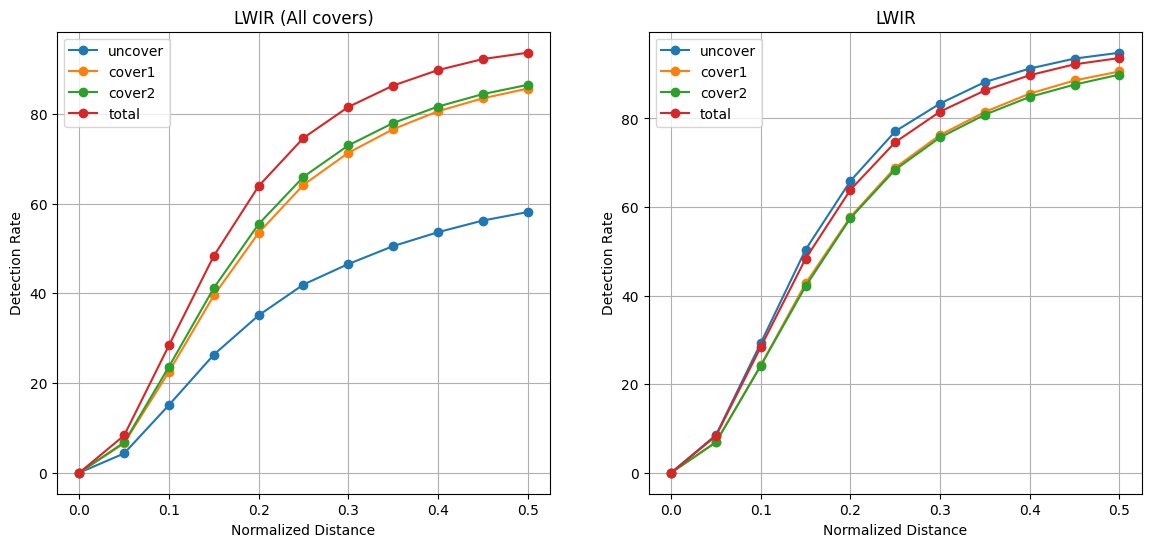

In [ ]:
mean_uncover_all = loaded_results_dict["results_IR_uncover"]['danaLab_all']['pck'][-1]
mean_cover1_all = loaded_results_dict["results_IR_cover1"]['danaLab_all']['pck'][-1]
mean_cover2_all = loaded_results_dict["results_IR_cover2"]['danaLab_all']['pck'][-1]
mean_total_all = loaded_results_dict["results_IR_total"]['danaLab']['pck'][-1]

mean_uncover = loaded_results_dict["results_IR_uncover"]['danaLab']['pck'][-1]
mean_cover1 = loaded_results_dict["results_IR_cover1"]['danaLab']['pck'][-1]
mean_cover2 = loaded_results_dict["results_IR_cover2"]['danaLab']['pck'][-1]
mean_total = loaded_results_dict["results_IR_total"]['danaLab']['pck'][-1]

ticks = np.linspace(0, 0.5, 11)

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First subplot
axs[0].plot(ticks, mean_uncover_all, label="uncover", marker='o')
axs[0].plot(ticks, mean_cover1_all, label="cover1", marker='o')
axs[0].plot(ticks, mean_cover2_all, label="cover2", marker='o')
axs[0].plot(ticks, mean_total_all, label="total", marker='o')
axs[0].set_title("LWIR (All covers)")
axs[0].set_xlabel("Normalized Distance")
axs[0].set_ylabel("Detection Rate")
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(ticks, mean_uncover, label="uncover", marker='o')
axs[1].plot(ticks, mean_cover1, label="cover1", marker='o')
axs[1].plot(ticks, mean_cover2, label="cover2", marker='o')
axs[1].plot(ticks, mean_total, label="total", marker='o')
axs[1].set_title("LWIR")
axs[1].set_xlabel("Normalized Distance")
axs[1].set_ylabel("Detection Rate")
axs[1].legend()
axs[1].grid(True)
plt.savefig('plots/LWIR.png')
plt.show()

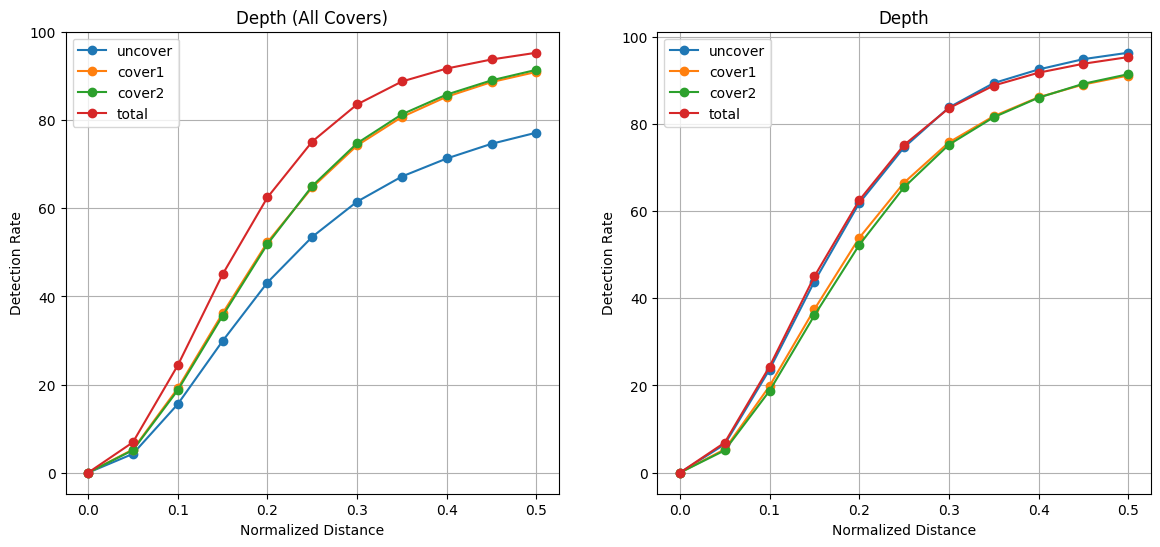

In [ ]:
mean_uncover_all = loaded_results_dict["results_depth_uncover"]['danaLab_all']['pck'][-1]
mean_cover1_all = loaded_results_dict["results_depth_cover1"]['danaLab_all']['pck'][-1]
mean_cover2_all = loaded_results_dict["results_depth_cover2"]['danaLab_all']['pck'][-1]
mean_total_all = loaded_results_dict["results_depth_total"]['danaLab']['pck'][-1]

mean_uncover = loaded_results_dict["results_depth_uncover"]['danaLab']['pck'][-1]
mean_cover1 = loaded_results_dict["results_depth_cover1"]['danaLab']['pck'][-1]
mean_cover2 = loaded_results_dict["results_depth_cover2"]['danaLab']['pck'][-1]
mean_total = loaded_results_dict["results_depth_total"]['danaLab']['pck'][-1]

ticks = np.linspace(0, 0.5, 11)

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First subplot
axs[0].plot(ticks, mean_uncover_all, label="uncover", marker='o')
axs[0].plot(ticks, mean_cover1_all, label="cover1", marker='o')
axs[0].plot(ticks, mean_cover2_all, label="cover2", marker='o')
axs[0].plot(ticks, mean_total_all, label="total", marker='o')
axs[0].set_title("Depth (All Covers)")
axs[0].set_xlabel("Normalized Distance")
axs[0].set_ylabel("Detection Rate")
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(ticks, mean_uncover, label="uncover", marker='o')
axs[1].plot(ticks, mean_cover1, label="cover1", marker='o')
axs[1].plot(ticks, mean_cover2, label="cover2", marker='o')
axs[1].plot(ticks, mean_total, label="total", marker='o')
axs[1].set_title("Depth")
axs[1].set_xlabel("Normalized Distance")
axs[1].set_ylabel("Detection Rate")
axs[1].legend()
axs[1].grid(True)
plt.savefig('plots/Depth.png')
plt.show()

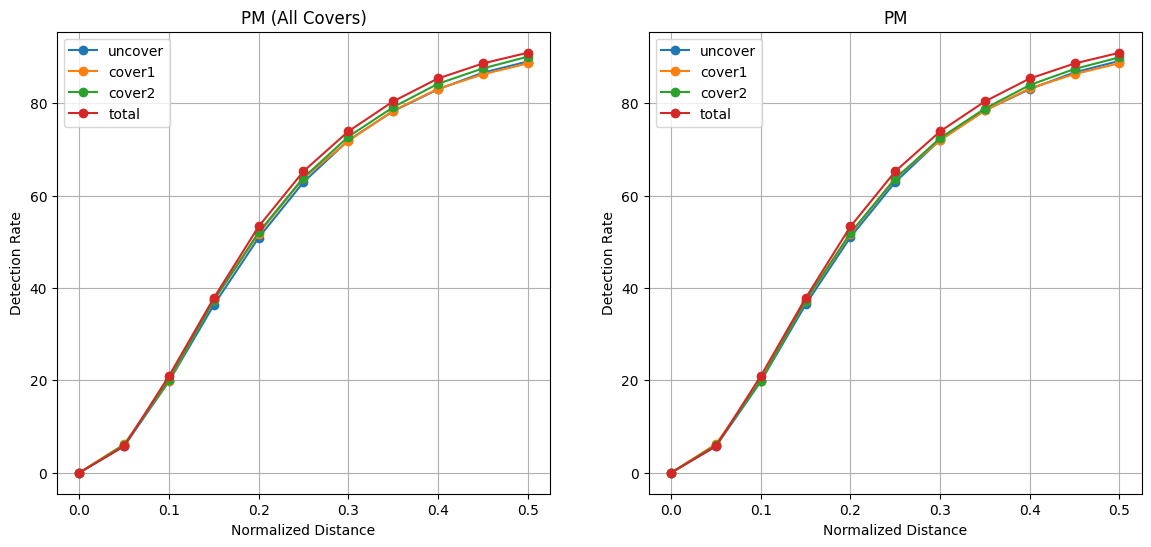

In [ ]:
mean_uncover_all = loaded_results_dict["results_PM_uncover"]['danaLab_all']['pck'][-1]
mean_cover1_all = loaded_results_dict["results_PM_cover1"]['danaLab_all']['pck'][-1]
mean_cover2_all = loaded_results_dict["results_PM_cover2"]['danaLab_all']['pck'][-1]
mean_total_all = loaded_results_dict["results_PM_total"]['danaLab']['pck'][-1]

mean_uncover = loaded_results_dict["results_PM_uncover"]['danaLab']['pck'][-1]
mean_cover1 = loaded_results_dict["results_PM_cover1"]['danaLab']['pck'][-1]
mean_cover2 = loaded_results_dict["results_PM_cover2"]['danaLab']['pck'][-1]
mean_total = loaded_results_dict["results_PM_total"]['danaLab']['pck'][-1]

ticks = np.linspace(0, 0.5, 11)

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First subplot
axs[0].plot(ticks, mean_uncover_all, label="uncover", marker='o')
axs[0].plot(ticks, mean_cover1_all, label="cover1", marker='o')
axs[0].plot(ticks, mean_cover2_all, label="cover2", marker='o')
axs[0].plot(ticks, mean_total_all, label="total", marker='o')
axs[0].set_title("PM (All Covers)")
axs[0].set_xlabel("Normalized Distance")
axs[0].set_ylabel("Detection Rate")
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(ticks, mean_uncover, label="uncover", marker='o')
axs[1].plot(ticks, mean_cover1, label="cover1", marker='o')
axs[1].plot(ticks, mean_cover2, label="cover2", marker='o')
axs[1].plot(ticks, mean_total, label="total", marker='o')
axs[1].set_title("PM")
axs[1].set_xlabel("Normalized Distance")
axs[1].set_ylabel("Detection Rate")
axs[1].legend()
axs[1].grid(True)
plt.savefig('plots/PM.png')
plt.show()

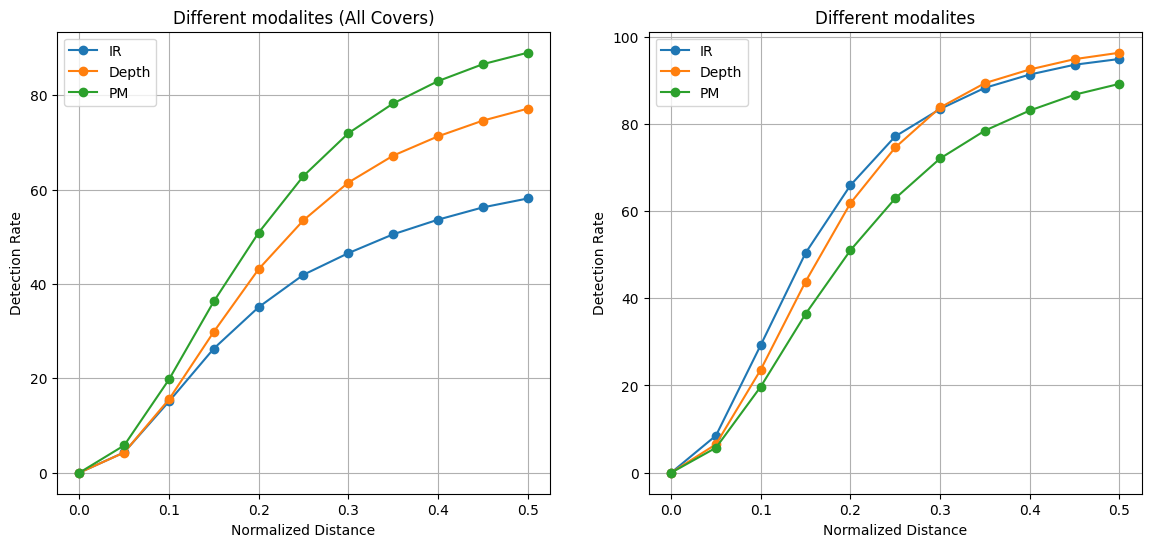

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'loaded_results_dict' is previously defined with all your results

mean_uncover_IR_all = loaded_results_dict["results_IR_uncover"]['danaLab_all']['pck'][-1]
mean_uncover_depth_all = loaded_results_dict["results_depth_uncover"]['danaLab_all']['pck'][-1]
mean_uncover_PM_all = loaded_results_dict["results_PM_uncover"]['danaLab_all']['pck'][-1]

mean_uncover_IR = loaded_results_dict["results_IR_uncover"]['danaLab']['pck'][-1]
mean_uncover_depth = loaded_results_dict["results_depth_uncover"]['danaLab']['pck'][-1]
mean_uncover_PM = loaded_results_dict["results_PM_uncover"]['danaLab']['pck'][-1]

ticks = np.linspace(0, 0.5, 11)

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First subplot
axs[0].plot(ticks, mean_uncover_IR_all, label="IR", marker='o')
axs[0].plot(ticks, mean_uncover_depth_all, label="Depth", marker='o')
axs[0].plot(ticks, mean_uncover_PM_all, label="PM", marker='o')
axs[0].set_title("Different modalites (All Covers)")
axs[0].set_xlabel("Normalized Distance")
axs[0].set_ylabel("Detection Rate")
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(ticks, mean_uncover_IR, label="IR", marker='o')
axs[1].plot(ticks, mean_uncover_depth, label="Depth", marker='o')
axs[1].plot(ticks, mean_uncover_PM, label="PM", marker='o')
axs[1].set_title("Different modalites")
axs[1].set_xlabel("Normalized Distance")
axs[1].set_ylabel("Detection Rate")
axs[1].legend()
axs[1].grid(True)
plt.savefig('plots/Different_modalites_cov0.png')
plt.show()


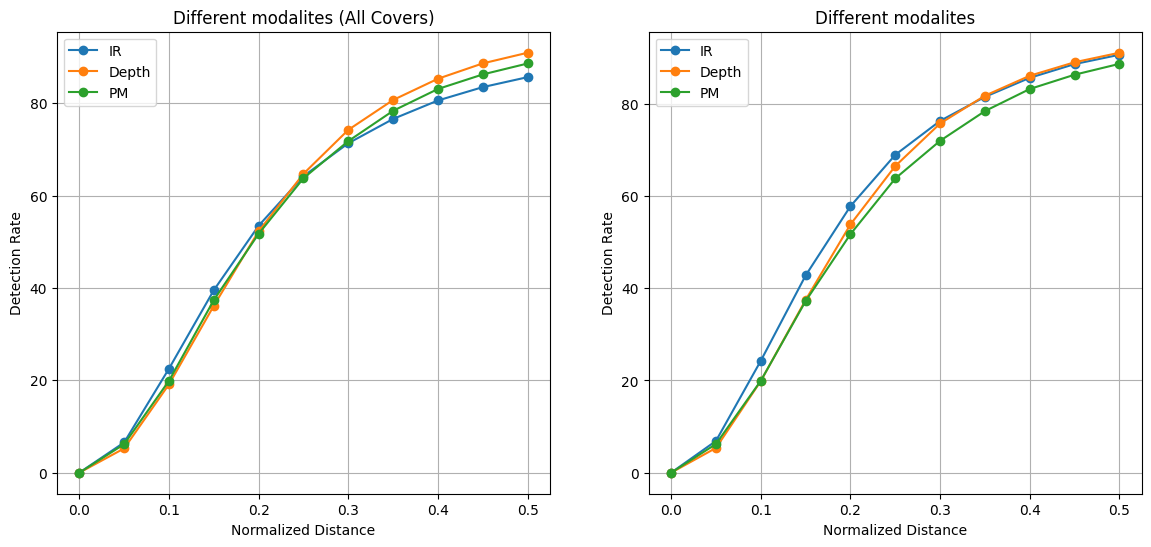

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'loaded_results_dict' is previously defined with all your results

mean_uncover_IR_all = loaded_results_dict["results_IR_cover1"]['danaLab_all']['pck'][-1]
mean_uncover_depth_all = loaded_results_dict["results_depth_cover1"]['danaLab_all']['pck'][-1]
mean_uncover_PM_all = loaded_results_dict["results_PM_cover1"]['danaLab_all']['pck'][-1]

mean_uncover_IR = loaded_results_dict["results_IR_cover1"]['danaLab']['pck'][-1]
mean_uncover_depth = loaded_results_dict["results_depth_cover1"]['danaLab']['pck'][-1]
mean_uncover_PM = loaded_results_dict["results_PM_cover1"]['danaLab']['pck'][-1]

ticks = np.linspace(0, 0.5, 11)

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First subplot
axs[0].plot(ticks, mean_uncover_IR_all, label="IR", marker='o')
axs[0].plot(ticks, mean_uncover_depth_all, label="Depth", marker='o')
axs[0].plot(ticks, mean_uncover_PM_all, label="PM", marker='o')
axs[0].set_title("Different modalites (All Covers)")
axs[0].set_xlabel("Normalized Distance")
axs[0].set_ylabel("Detection Rate")
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(ticks, mean_uncover_IR, label="IR", marker='o')
axs[1].plot(ticks, mean_uncover_depth, label="Depth", marker='o')
axs[1].plot(ticks, mean_uncover_PM, label="PM", marker='o')
axs[1].set_title("Different modalites")
axs[1].set_xlabel("Normalized Distance")
axs[1].set_ylabel("Detection Rate")
axs[1].legend()
axs[1].grid(True)
plt.savefig('plots/Different_modalites_cov1.png')
plt.show()

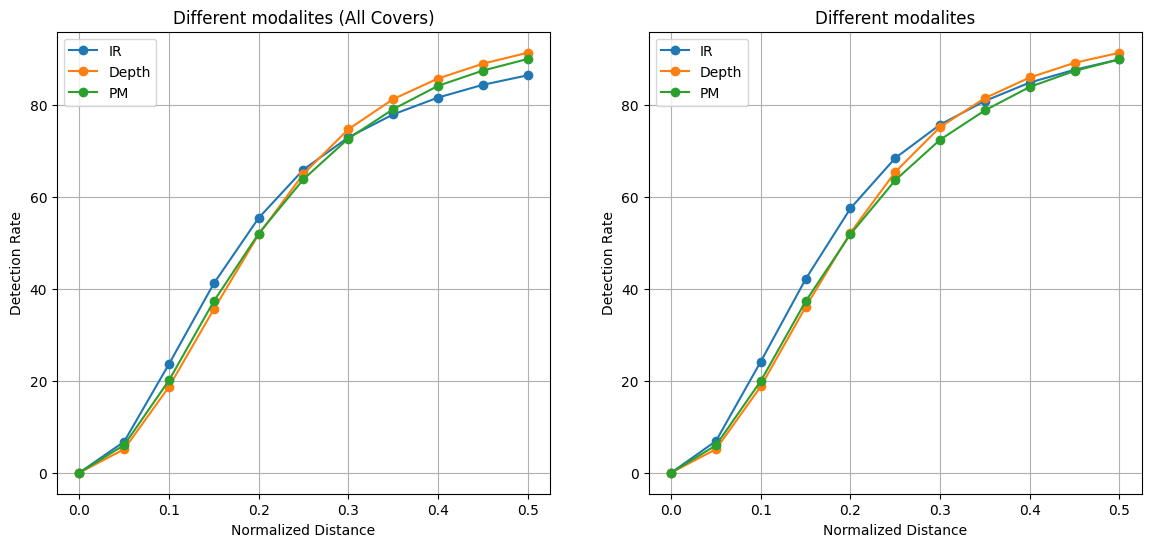

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'loaded_results_dict' is previously defined with all your results

mean_uncover_IR_all = loaded_results_dict["results_IR_cover2"]['danaLab_all']['pck'][-1]
mean_uncover_depth_all = loaded_results_dict["results_depth_cover2"]['danaLab_all']['pck'][-1]
mean_uncover_PM_all = loaded_results_dict["results_PM_cover2"]['danaLab_all']['pck'][-1]

mean_uncover_IR = loaded_results_dict["results_IR_cover2"]['danaLab']['pck'][-1]
mean_uncover_depth = loaded_results_dict["results_depth_cover2"]['danaLab']['pck'][-1]
mean_uncover_PM = loaded_results_dict["results_PM_cover2"]['danaLab']['pck'][-1]

ticks = np.linspace(0, 0.5, 11)

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First subplot
axs[0].plot(ticks, mean_uncover_IR_all, label="IR", marker='o')
axs[0].plot(ticks, mean_uncover_depth_all, label="Depth", marker='o')
axs[0].plot(ticks, mean_uncover_PM_all, label="PM", marker='o')
axs[0].set_title("Different modalites (All Covers)")
axs[0].set_xlabel("Normalized Distance")
axs[0].set_ylabel("Detection Rate")
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(ticks, mean_uncover_IR, label="IR", marker='o')
axs[1].plot(ticks, mean_uncover_depth, label="Depth", marker='o')
axs[1].plot(ticks, mean_uncover_PM, label="PM", marker='o')
axs[1].set_title("Different modalites")
axs[1].set_xlabel("Normalized Distance")
axs[1].set_ylabel("Detection Rate")
axs[1].legend()
axs[1].grid(True)
plt.savefig('plots/Different_modalites_cov2.png')
plt.show()

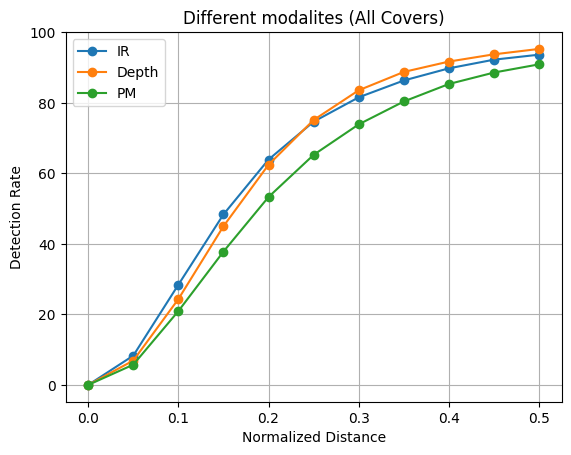

In [ ]:
import matplotlib.pyplot as plt
mean_uncover_IR = loaded_results_dict["results_IR_total"]['danaLab']['pck'][-1]
mean_uncover_depth = loaded_results_dict["results_depth_total"]['danaLab']['pck'][-1]
mean_uncover_PM = loaded_results_dict["results_PM_total"]['danaLab']['pck'][-1]
ticks = np.linspace(0, 0.5, 11)
# Plotting
plt.plot(ticks, mean_uncover_IR, label="IR", marker='o')
plt.plot(ticks, mean_uncover_depth, label="Depth", marker='o')
plt.plot(ticks, mean_uncover_PM, label="PM", marker='o')

plt.title("Different modalites (All Covers)")
plt.xlabel("Normalized Distance")
plt.ylabel("Detection Rate")
plt.legend()
plt.grid(True)
plt.savefig('plots/Different_modalites_total.png')
plt.show()

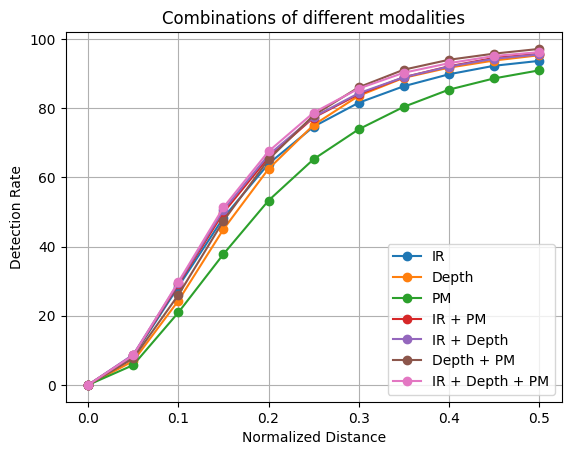

In [ ]:
import matplotlib.pyplot as plt
mean_IR_PM = loaded_results_dict['results_IR_PM_total']['danaLab']['pck'][-1]
mean_IR_Depth = loaded_results_dict['results_IR_depth_total']['danaLab']['pck'][-1]
mean_Depth_PM = loaded_results_dict['results_PM_depth_total']['danaLab']['pck'][-1]
mean_IR_Depth_PM = loaded_results_dict['results_IR_depth_PM_total']['danaLab']['pck'][-1]
mean_IR_total = loaded_results_dict['results_IR_total']['danaLab']['pck'][-1]
mean_depth_total = loaded_results_dict['results_depth_total']['danaLab']['pck'][-1]
mean_PM_total = loaded_results_dict['results_PM_total']['danaLab']['pck'][-1]
ticks = np.linspace(0, 0.5, 11)

# Plotting
plt.plot(ticks, mean_IR_total, label="IR", marker='o')
plt.plot(ticks, mean_depth_total, label="Depth", marker='o')
plt.plot(ticks, mean_PM_total, label="PM", marker='o')
plt.plot(ticks, mean_IR_PM, label="IR + PM", marker='o')
plt.plot(ticks, mean_IR_Depth, label="IR + Depth", marker='o')
plt.plot(ticks, mean_Depth_PM, label="Depth + PM", marker='o')
plt.plot(ticks, mean_IR_Depth_PM, label="IR + Depth + PM", marker='o')

plt.title("Combinations of different modalities")
plt.xlabel("Normalized Distance")
plt.ylabel("Detection Rate")
plt.legend()
plt.grid(True)
plt.savefig('plots/Combinations.png')
plt.show()

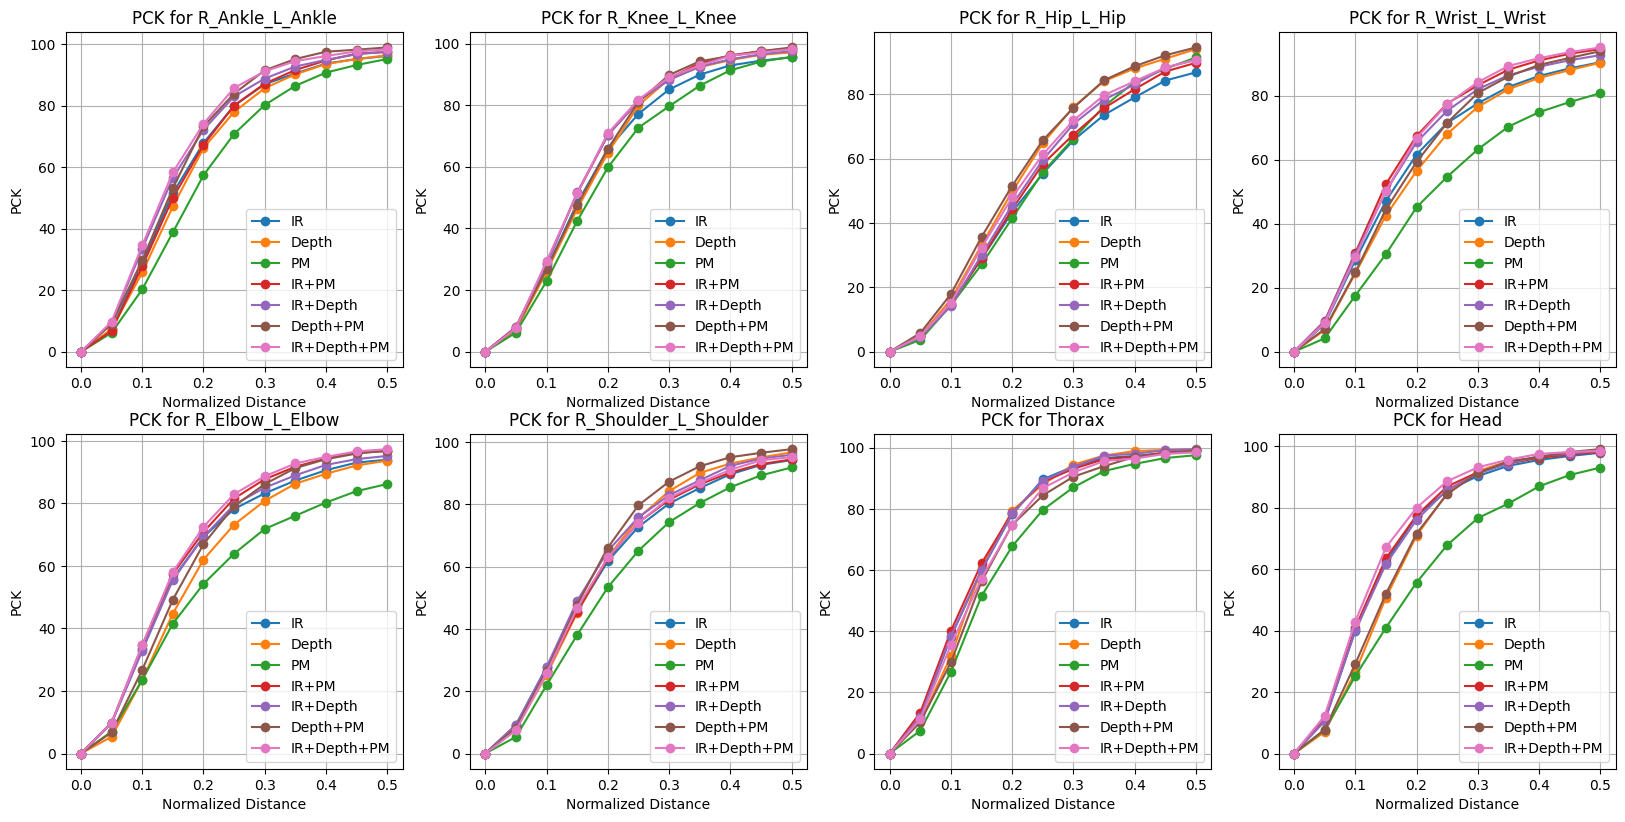

In [ ]:
# Define paired joints
paired_joints = [("R_Ankle", "L_Ankle"), ("R_Knee", "L_Knee"), ("R_Hip", "L_Hip"),
                 ("R_Wrist", "L_Wrist"), ("R_Elbow", "L_Elbow"), ("R_Shoulder", "L_Shoulder")]

# Calculate the mean for paired joints
mean_values = {}
for pair in paired_joints:
    index1 = joints.index(pair[0])
    index2 = joints.index(pair[1])
    for label, mean_data in [("IR", mean_IR_total), ("Depth", mean_depth_total),
                             ("PM", mean_PM_total), ("IR+PM", mean_IR_PM),
                             ("IR+Depth", mean_IR_Depth), ("Depth+PM", mean_Depth_PM),
                             ("IR+Depth+PM", mean_IR_Depth_PM)]:

        mean_values[f"{pair[0]}_{pair[1]}_{label}"] = np.mean([mean_data[index1], mean_data[index2]], axis=0)

# Other joints you might want to include without averaging
solo_joints = ["Thorax", "Head"]

# Include them in the plotting
for joint in solo_joints:
    index = joints.index(joint)
    for label, mean_data in [("IR", mean_IR_total), ("Depth", mean_depth_total),
                             ("PM", mean_PM_total), ("IR+PM", mean_IR_PM),
                             ("IR+Depth", mean_IR_Depth), ("Depth+PM", mean_Depth_PM),
                             ("IR+Depth+PM", mean_IR_Depth_PM)]:

        mean_values[f"{joint}_{label}"] = mean_data[index]

# Create figure
plt.figure(figsize=(20, 20))

# Loop through each joint pair and solo joints and plot
for i, joint_pair in enumerate(paired_joints + list(solo_joints)):
    plt.subplot(4, 4, i+1)

    joint_label = f"{joint_pair[0]}_{joint_pair[1]}" if isinstance(joint_pair, tuple) else joint_pair

    for label in ["IR", "Depth", "PM", "IR+PM", "IR+Depth", "Depth+PM", "IR+Depth+PM"]:
        plt.plot(ticks, mean_values[f"{joint_label}_{label}"], label=label, marker='o')

    plt.xlabel('Normalized Distance')
    plt.ylabel('PCK')
    plt.title(f'PCK for {joint_label}')

    plt.legend()
    plt.grid(True)

# Save and show figure
plt.savefig('Averaged_PCK.png')
plt.show()


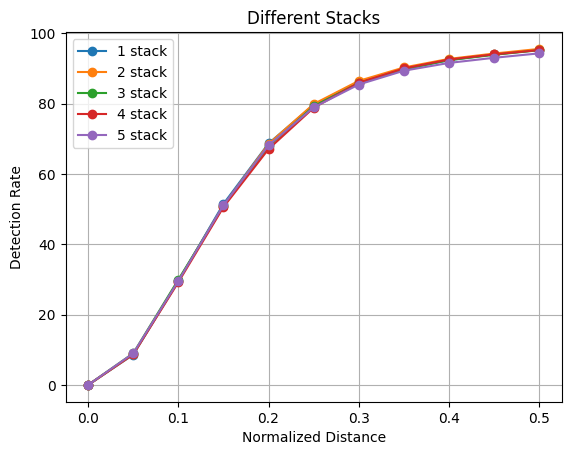

In [ ]:
import matplotlib.pyplot as plt
stack1 = loaded_results_dict['results_IR_total_stack1']['simLab']['pck'][-1]
stack2 = loaded_results_dict['results_IR_total_stack2']['simLab']['pck'][-1]
stack3 = loaded_results_dict['results_IR_total_stack3']['simLab']['pck'][-1]
stack4 = loaded_results_dict['results_IR_total_stack4']['simLab']['pck'][-1]
stack5 = loaded_results_dict['results_IR_total_stack5']['simLab']['pck'][-1]
ticks = np.linspace(0, 0.5, 11)
# Plotting
plt.plot(ticks, stack1, label="1 stack", marker='o')
plt.plot(ticks, stack2, label="2 stack", marker='o')
plt.plot(ticks, stack3, label="3 stack", marker='o')
plt.plot(ticks, stack4, label="4 stack", marker='o')
plt.plot(ticks, stack5, label="5 stack", marker='o')

plt.title("Different Stacks")
plt.xlabel("Normalized Distance")
plt.ylabel("Detection Rate")
plt.legend()
plt.grid(True)
plt.savefig('plots/stacks.png')
plt.show()

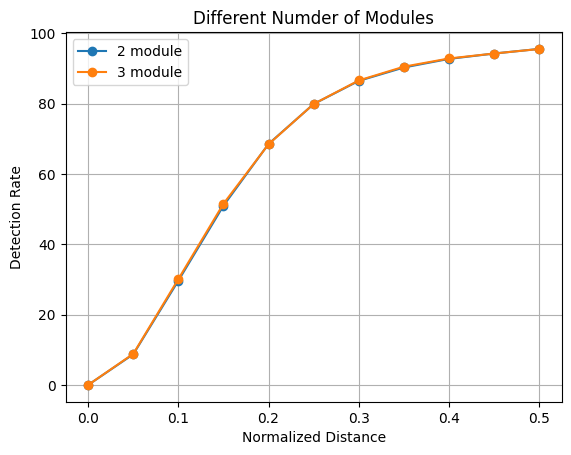

In [ ]:
import matplotlib.pyplot as plt
module2 = loaded_results_dict['results_IR_total_stack2_module2']['simLab']['pck'][-1]
module3 = loaded_results_dict['results_IR_total_stack2_module3']['simLab']['pck'][-1]
ticks = np.linspace(0, 0.5, 11)
# Plotting
plt.plot(ticks, module2, label="2 module", marker='o')
plt.plot(ticks, module3, label="3 module", marker='o')


plt.title("Different Numder of Modules")
plt.xlabel("Normalized Distance")
plt.ylabel("Detection Rate")
plt.legend()
plt.grid(True)
plt.savefig('plots/Modules.png')
plt.show()

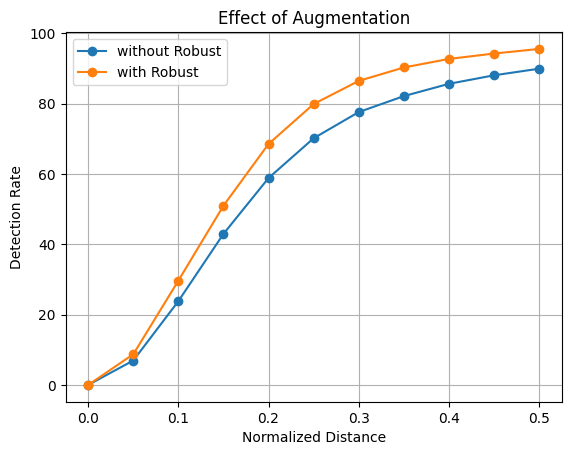

In [ ]:
import matplotlib.pyplot as plt
without_Robust = loaded_results_dict['results_IR_total_without_Robust']['simLab']['pck'][-1]
with_Robust = loaded_results_dict['results_IR_total_with_Robust']['simLab']['pck'][-1]
ticks = np.linspace(0, 0.5, 11)
# Plotting
plt.plot(ticks, without_Robust, label="without Robust", marker='o')
plt.plot(ticks, with_Robust, label="with Robust", marker='o')


plt.title("Effect of Augmentation")
plt.xlabel("Normalized Distance")
plt.ylabel("Detection Rate")
plt.legend()
plt.grid(True)
plt.savefig('plots/Augmentation.png')
plt.show()

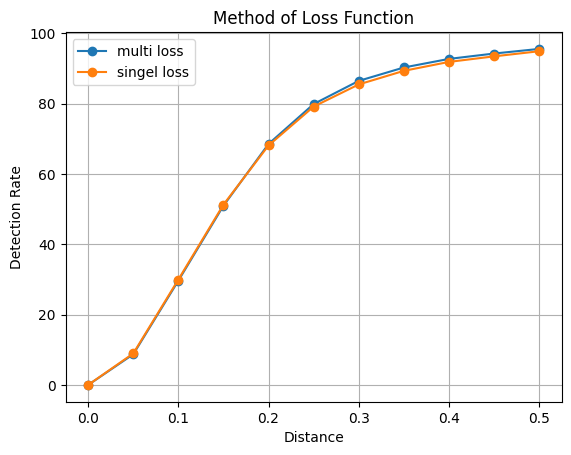

In [ ]:
import matplotlib.pyplot as plt
mu_loss = loaded_results_dict['results_IR_total_mu_loss']['simLab']['pck'][-1]
singel_loss = loaded_results_dict['results_IR_total_singel_loss']['simLab']['pck'][-1]
ticks = np.linspace(0, 0.5, 11)
# Plotting
plt.plot(ticks, mu_loss, label="multi loss", marker='o')
plt.plot(ticks, singel_loss, label="singel loss", marker='o')


plt.title("Method of Loss Function")
plt.xlabel("Distance")
plt.ylabel("Detection Rate")
plt.legend()
plt.grid(True)
plt.savefig('plots/Loss.png')
plt.show()

In [ ]:
pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4)
pars.files()
checkpoint_file = os.path.join(pars.model_dir, 'checkpoint.pth')
print("=> loading checkpoint '{}'".format(checkpoint_file))
checkpoint = torch.load(checkpoint_file)
begin_epoch = checkpoint['epoch']
best_perf = checkpoint['perf']
last_epoch = checkpoint['epoch']
accs_train_robust = np.array(checkpoint['accs_trian']).reshape(-1,405).mean(axis=1)
accs_val_robust = np.array(checkpoint['accs_val']).reshape(-1,54).mean(axis=1)

pars = parameters(use_gpu=True, mod_src=['IR'], cover_list=['uncover', 'cover1', 'cover2'],end_epoch=50, nChannels=256, nStack=2, nModules=2,numReductions=4, robust=False, output_dir='robust_out' )
pars.files()

checkpoint_file = os.path.join(pars.model_dir, 'checkpoint.pth')
print("=> loading checkpoint '{}'".format(checkpoint_file))
checkpoint = torch.load(checkpoint_file)
begin_epoch = checkpoint['epoch']
best_perf = checkpoint['perf']
last_epoch = checkpoint['epoch']
accs_train_unrobust = np.array(checkpoint['accs_trian']).reshape(-1,405).mean(axis=1)
accs_val_unrobust = np.array(checkpoint['accs_val']).reshape(-1,54).mean(axis=1)

=> loading checkpoint 'output/StackedHourGlass_256_2_2_4multi_loss/SLP_IR___u12/model_dump/checkpoint.pth'
=> loading checkpoint 'robust_outStackedHourGlass_256_2_2_4multi_loss/SLP_IR___u12/model_dump/checkpoint.pth'


(50,)
(50,)


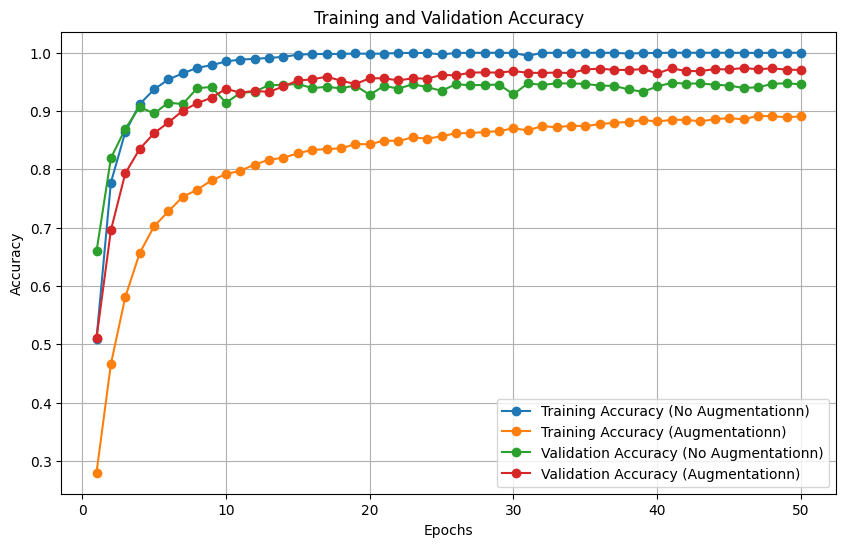

In [ ]:
epochs = range(1, len(accs_train_unrobust) + 1)

# Create a new figure
plt.figure(figsize=(10, 6))
print(accs_train_unrobust.shape)
print(accs_train_robust.shape)
# Plot training accuracies
plt.plot(epochs, accs_train_unrobust, label='Training Accuracy (No Augmentationn)', marker='o')
plt.plot(epochs, accs_train_robust, label='Training Accuracy (Augmentationn)', marker='o')

# Plot validation accuracies
plt.plot(epochs, accs_val_unrobust, label='Validation Accuracy (No Augmentationn)', marker='o')
plt.plot(epochs, accs_val_robust, label='Validation Accuracy (Augmentationn)', marker='o')

# Add titles and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add legend and grid
plt.legend()
plt.grid(True)
plt.savefig('plots/Acc.png')
# Show the plot
plt.show()